**In this notebook we generate simulated datasets, and save files for clustering**

In [694]:
import h5py
import scanpy as sc
import anndata
import loompy as lp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys

import scipy
import tqdm
from scipy import integrate, fft, sparse

import random


## **Define Functions for Simulations**

In [695]:
class BurstModel():
    """
    Given parameters for bursty transcription, splicing, deg generate P(U,S) for set of (U,S) counts
    """
    def __init__(self,seq_model='None',quad_method='fixed_quad',fixed_quad_T=10,quad_order=60,quad_vec_T=np.inf):
        self.seq_model = seq_model
        self.quad_method = quad_method
        self.fixed_quad_T = fixed_quad_T
        self.quad_order = quad_order
        self.quad_vec_T = quad_vec_T
        
    def burst_intfun(self, x, g, b, beta, gamma):
        if np.isclose(beta, gamma):
            c_1 = g[0]  
            c_2 = x * beta * g[1]
        else:
            f = beta / (beta - gamma)
            c_2 = g[1] * f
            c_1 = g[0] - c_2

        U = b * (np.exp(-beta * x) * c_1 + np.exp(-gamma * x) * c_2)
        return U / (1 - U)    
    
    def eval_model_pgf(self, p_, g):
        p = 10**p_
        b, beta, gamma = p

        
        fun = lambda x: self.burst_intfun(x, g, b, beta, gamma)
        if self.quad_method == "quad_vec":
            T = self.quad_vec_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.quad_vec(fun, 0, T)[0]
        elif self.quad_method == "fixed_quad":
            T = self.fixed_quad_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.fixed_quad(fun, 0, T, n=self.quad_order)[0]
        else:
            raise ValueError("Please use one of the specified quadrature methods.")
        return gf  # this is the log-generating function

    def get_Pss(self, p, limits, samp=None):
        u = []
        mx = np.copy(limits)
        mx[-1] = mx[-1] // 2 + 1
        for i in range(len(mx)):
            l = np.arange(mx[i])
            u_ = np.exp(-2j * np.pi * l / limits[i]) - 1
            u.append(u_)
        g = np.meshgrid(*[u_ for u_ in u], indexing="ij")
        for i in range(len(mx)):
            g[i] = g[i].flatten()
        g = np.asarray(g)[:, :, None]

        if self.seq_model == "Bernoulli":
            g *= np.asarray(samp)[:, None, None]
        elif self.seq_model == "Poisson":
            g = np.exp((np.power(10, samp))[:, None, None] * g) - 1

        gf = self.eval_model_pgf(p, g)
        gf = np.exp(gf)
        gf = gf.reshape(tuple(mx))
        
        
        Pss = scipy.fft.irfftn(gf, s=tuple(limits))
        
        
        Pss = np.abs(Pss) / np.sum(np.abs(Pss))
        
        Pss = Pss.squeeze()
        return Pss

In [696]:
def sample_from_p(num_data_points, Pss):
    """
    Given a P(U,S) distribution, sample (U,S) counts
    N = U (nascent/unspliced)
    M = S (mature/spliced)
    """
    mx = Pss.shape
    p_flat = Pss.flatten()
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')    # get grid of possible values
    x_choices = np.arange(np.prod(mx))                 # represent each grid point as a point in a 1D vector
    
    samples = np.random.choice(x_choices, size=num_data_points, replace=True, p=p_flat)
    d_N, d_M = X_N.flatten()[samples], X_M.flatten()[samples]    
    return d_N, d_M

## **Generate Counts**

In [697]:
def make_params(clus,n_genes,lens_sub,samples,glob_samp,num_marks,p=1.0,loc=1.5,lessp_param='b',greatp_param='beta'):
    """
    Given number of clusters (states),genes, and markers per cluster, generate parameters per cluster (state).
    With probability p add noise to b for markers (and change other params with p=1-p)
    """
    #For each gene set params (clus x n_genes x 6), use gene lens from transcriptome file + use same gene names 
    params = np.zeros((clus,n_genes,6)) #b,k,beta,gamma,samp_n,samp_m, ALL LOG10
    for g in range(n_genes):
        g_len = lens_sub[g]
        params[:,g,0] = samples[g,0] + np.random.randn()*0.05 #int(np.random.uniform(8,12)) #b
        params[:,g,1] = 0 #np.random.uniform(0.1,0.5) #k
        params[:,g,2] = samples[g,1] + np.random.randn()*0.05 #np.random.normal(2,0.1)  #beta
        params[:,g,3] = samples[g,2] + np.random.randn()*0.05 #np.random.normal(0.8,0.1) #gamma

        params[:,g,4] = (glob_samp[0]) + np.log10(g_len) #C_nL
        params[:,g,5] = (glob_samp[1]) #lam_m


    pos_dict = {'b':[0],'beta': [2],'gamma': [3],'k':[2,3]}

    noise = 0.1
    #For each clus, select num_marks unique markers, add noise to b (log10b)
    all_choices = np.random.choice(range(n_genes), num_marks*clus, replace=False)
    if num_marks > 0:
        for c in range(clus):
            marks = all_choices[c*num_marks:(c+1)*num_marks]

            #UPDATE to change either b or beta&gamma
            for m in marks:
                if np.random.rand() < p:
                    chosen = pos_dict[lessp_param]
                    if len(chosen) == 1:
                        if lessp_param == 'b':
                            params[c,m,chosen[0]] += loc+np.random.randn()*noise  
                        else:
                            params[c,m,chosen[0]] -= loc+np.random.randn()*noise  
                    else: #Change in k
                        params[c,m,chosen[0]] -= loc+np.random.randn()*noise #np.random.normal(loc=loc, scale = 0.1)
                        params[c,m,chosen[1]] -= loc+np.random.randn()*noise
                        
                else:
                    chosen = pos_dict[greatp_param]
                    if len(chosen) == 1:
                        if greatp_param == 'b':
                            params[c,m,chosen[0]] += loc+np.random.randn()*noise  
                        else:
                            params[c,m,chosen[0]] -= loc+np.random.randn()*noise
                    else: #Change in k
                        params[c,m,chosen[0]] -= loc+np.random.randn()*noise #np.random.normal(loc=loc, scale = 0.1)
                        params[c,m,chosen[1]] -= loc+np.random.randn()*noise
                        
                    

    return params,all_choices


In [698]:
def make_dbl_params(clus,n_genes,lens_sub,samples,glob_samp,num_marks,p=1.0,loc=1.5,pair=['b','beta']):
    """
    Given number of clusters (states),genes, and markers per cluster, generate parameters per cluster (state).
    With probability p add noise to both params for markers (and change only one param with p=1-p)
    """
    #For each gene set params (clus x n_genes x 6), use gene lens from transcriptome file + use same gene names 
    params = np.zeros((clus,n_genes,6)) #b,k,beta,gamma,samp_n,samp_m, ALL LOG10
    for g in range(n_genes):
        g_len = lens_sub[g]
        params[:,g,0] = samples[g,0] + np.random.randn()*0.05 #int(np.random.uniform(8,12)) #b
        params[:,g,1] = 0 #np.random.uniform(0.1,0.5) #k
        params[:,g,2] = samples[g,1] + np.random.randn()*0.05 #np.random.normal(2,0.1)  #beta
        params[:,g,3] = samples[g,2] + np.random.randn()*0.05 #np.random.normal(0.8,0.1) #gamma

        params[:,g,4] = (glob_samp[0]) + np.log10(g_len) #C_nL
        params[:,g,5] = (glob_samp[1]) #lam_m


    pos_dict = {'b':[0],'beta': [2],'gamma': [3]}

    noise = 0.1
    #For each clus, select num_marks unique markers, add noise to b (log10b)
    all_choices = np.random.choice(range(n_genes), num_marks*clus, replace=False)
    if num_marks > 0:
        for c in range(clus):
            marks = all_choices[c*num_marks:(c+1)*num_marks]

            #UPDATE to change either b or beta&gamma
            for m in marks:
                if np.random.rand() < p:
                    chosen = [pos_dict[i] for i in pair]
                    for x in chosen:
                        params[c,m,x] += loc+np.random.randn()*noise  #Change both
                else:
                    chosen = [pos_dict[i] for i in pair]
                    
                    if np.random.rand() < 0.5:
                        if chosen[0] == 0:
                            params[c,m,chosen[0]] += loc+np.random.randn()*noise  
                        else:
                            params[c,m,chosen[0]] -= loc+np.random.randn()*noise
                    else:
                        if chosen[1] == 0:
                            params[c,m,chosen[1]] += loc+np.random.randn()*noise  
                        else:
                            params[c,m,chosen[1]] -= loc+np.random.randn()*noise
                    
                    

    return params,all_choices


In [699]:
def make_counts(clus,n_cells,n_genes,params):
    """
    For each cluster+gene, generate counts (U,S) from parameters 
    """
    #Given parameters, sample counts from resulting probability distribution
    all_counts = np.zeros((np.sum(n_cells),n_genes,2))
    pos_ind = 0
    for c in range(clus):

        for g in range(n_genes):

            b = 10**params[c,g,0]
            k = 10**params[c,g,1]
            beta = 10**params[c,g,2]
            gamma = 10**params[c,g,3]

            lam_n = 10**params[c,g,4]
            lam_m = 10**params[c,g,5]

            p = np.log10(np.asarray([b,beta/k,gamma/k]))
            burst_model = BurstModel('Poisson')

            max_mean = b*np.asarray([lam_n/beta,lam_m/gamma]) #np.array(samp)*
            #max_std = np.sqrt(max_mean*(1+ b*np.asarray([1,beta/(beta+gamma)])))

            max_std = np.sqrt(max_mean*(1+np.asarray([lam_n*(1+b), lam_m*(1+b*beta/(beta+gamma))])))

            max_domain = np.maximum((max_mean + 4*max_std).astype(int),15)
            #max_domain = [int(i) for i in max_domain]

            Pss = burst_model.get_Pss(p,max_domain,np.log10([lam_n,lam_m]))

            #Get N and M count samples
            sampled = sample_from_p(n_cells[c], Pss)
            all_counts[pos_ind:pos_ind+n_cells[c],g,0] = sampled[0]
            all_counts[pos_ind:pos_ind+n_cells[c],g,1] = sampled[1]
            
        pos_ind += n_cells[c]
        print('pos_ind: ',pos_ind)
            
    return all_counts

In [737]:
np.sum([100,300,500,1000,1500])

3400

Set parameters for simulation

In [700]:
#No. of cells PER k cell 'type'/stats
n_cells = [[100,100,200,200,300,500,500,1000,800,1300],[100,300,500,1000,1500]]  # !** orig [100,100,300,500,500,1000,1000,1500]  !**
clus =  [len(n_cells[0]),len(n_cells[1])] #No. of states to simulate

In [701]:
n_genes = [1100,700] #No. genes, 1000
num_marks = [100,100] #No. markers per state, !** 100 before !***

In [702]:
#Technical sampling params
glob_samp = np.asarray([-6.777777777777778, -1.25])

In [703]:
transcriptome = pd.read_csv('/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3',delim_whitespace=True,header = None)
transcriptome.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,TNMD,14950,48,23,10,5,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
1,DPM1,23689,98,38,25,17,10,6,5,5,...,0,0,0,0,0,0,0,0,0,0
2,SCYL3,44637,132,51,20,13,9,7,6,4,...,0,0,0,0,0,0,0,0,0,0
3,TSPAN6,12884,43,18,13,8,3,2,2,1,...,0,0,0,0,0,0,0,0,0,0
4,FGR,23122,41,18,8,4,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [704]:
#Initialize params and correlations, per gene
np.random.seed(40)

mean = np.asarray([1.2, 0.2, 0.5, 5]) #b, beta, gamma, L 
std = np.asarray([0.6, 0.3, 0.5, 0.5]) 
var = std[:, None] * std[None, :] #Make covariance matrix
rho = [0.8, 0.8, 0.8, -0.1, 0, 0] #Incorporate corrs b/w params
pairs = [[1, 2], [0, 1], [0, 2], [0, 3], [1, 3], [2, 3]]
for k, p in enumerate(pairs):
    var[p[0], p[1]] *= rho[k]
    var[p[1], p[0]] *= rho[k]
    
samples = [np.random.multivariate_normal(mean, var, n_genes[i]) for i in range(len(n_genes))]


In [705]:
print(len(samples))
samples[0].shape

2


(1100, 4)

In [706]:
n_genes

[1100, 700]

In [707]:
#Select genes from real transcriptome
lens_sub = []
names_sub = []
for r in range(len(n_genes)):
    gene_names = np.array(transcriptome[0])

    names_sub += [gene_names[0:n_genes[r]]]


    transcriptome_sub = transcriptome[0:n_genes[r]]
    ls_sub = 10**samples[r][:,3]
    lens_sub += [ls_sub]
    transcriptome_sub[1] = [int(i) for i in ls_sub]
    transcriptome_sub.head()

    #make new transcriptome in same style
    transcriptome_sub.to_csv('/home/tchari/perturbCME/notebooks/sim_genome_polyA_cum_3_'+str(r),sep=' ', index=False)
    print('/home/tchari/perturbCME/notebooks/sim_genome_polyA_cum_3_'+str(r))


/home/tchari/perturbCME/notebooks/sim_genome_polyA_cum_3_0
/home/tchari/perturbCME/notebooks/sim_genome_polyA_cum_3_1


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Get (U,S) counts for each simulation setting

In [708]:
#loc=1.5,1.0
all_params = []
all_marks = []

out = make_params(clus[0],n_genes[0],lens_sub[0],samples[0],glob_samp,num_marks[0],p=0.2,loc=0.5,lessp_param='b',greatp_param='beta') #,p=0.2,loc=0.5
all_params += [out[0]]
all_marks += [out[1]]


out = make_params(clus[1],n_genes[1],lens_sub[1],samples[1],glob_samp,num_marks[1],p=0.2,loc=0.5,lessp_param='b',greatp_param='beta') #,p=0.2,loc=0.5
all_params += [out[0]]
all_marks += [out[1]]


# out = make_params(clus,n_genes,lens_sub,samples,glob_samp,num_marks,p=0.2,loc=0.5,lessp_param='b',greatp_param='beta')
# all_params += [out[0]]
# all_marks += [out[1]]


# out = make_params(clus,n_genes,lens_sub,samples,glob_samp,num_marks,p=0.2,loc=0.3,lessp_param='k',greatp_param='gamma')
# all_params += [out[0]]
# all_marks += [out[1]]

# !*** Changed to 0.3 from 0.5 !***


In [709]:
np.min(all_params[0])

-3.270746202006175

In [710]:
all_counts = []
for x in range(len(all_params)):
    all_counts += [make_counts(clus[x],n_cells[x],n_genes[x],all_params[x])]

pos_ind:  100
pos_ind:  200
pos_ind:  400
pos_ind:  600
pos_ind:  900
pos_ind:  1400
pos_ind:  1900
pos_ind:  2900
pos_ind:  3700
pos_ind:  5000
pos_ind:  100
pos_ind:  400
pos_ind:  900
pos_ind:  1900
pos_ind:  3400


In [711]:
all_assigns = []

for c in range(len(clus)):
    sub_assigns = []
    for i in range(clus[c]):
        sub_assigns += [i]*n_cells[c][i]
    all_assigns += [sub_assigns]

In [715]:
all_counts[0].shape

(5000, 1100, 2)

In [716]:
!rm -r /home/tchari/counts/meKMeans_sims/loom/

In [717]:
!mkdir /home/tchari/counts/meKMeans_sims
!mkdir /home/tchari/counts/meKMeans_sims/loom/

mkdir: cannot create directory ‘/home/tchari/counts/meKMeans_sims’: File exists


In [718]:
#Save all params and all marks
out_path = '/home/tchari/counts/meKMeans_sims/loom/'

print(np.array(all_params).shape)
np.save(out_path+'all_params.npy',np.array(all_params))
np.save(out_path+'all_marks.npy',np.array(all_marks))

(2,)


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do th

**Check sims**

Text(0, 0.5, 'log beta (beta)')

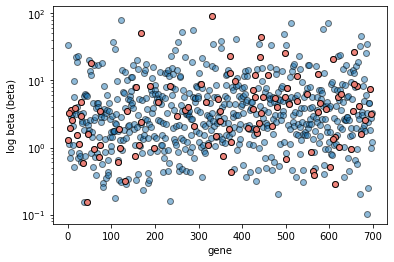

In [719]:
test_out = all_params[-1]
test_marks = all_marks[-1][0:num_marks[-1]]

plt.scatter(range(len(test_out[0,:,0])), 10**test_out[0,:,3],alpha=0.5,edgecolor='black')
plt.scatter(np.array(range(len(test_out[0,:,0])))[test_marks], 10**test_out[0,:,3][test_marks],color='salmon',alpha=0.9,edgecolor='black')
plt.yscale('log')
plt.xlabel('gene')
plt.ylabel('log beta (beta)')

**Save sims to loom files**

In [720]:
out_names = ['b_beta_sim_k8','k_gamma_sim_k8'] 

In [722]:
len(all_assigns[0])

5000

In [723]:
#And save clus labels for cells + barcodes for each cell in metadata + loom
out_path = '/home/tchari/counts/meKMeans_sims/loom/'

for ind in range(len(out_names)):
    geneNames = names_sub[ind]
    
    U = all_counts[ind][:,:,0]
    S = all_counts[ind][:,:,1]
    
    bars = [str(i) for i in range(np.sum(n_cells[ind]))]

    fname = out_path+out_names[ind]+'.loom'

    print('Making Loom')
    #Make loom of U/S
    subclass = all_assigns[ind]
    retAdata = anndata.AnnData(
                X=sparse.csr_matrix(S),
                layers={
                    'spliced': sparse.csr_matrix(S),
                    'unspliced': sparse.csr_matrix(U),
                },
                obs=pd.DataFrame({'barcode': np.array(bars),'subclass_label':subclass},index=np.array(bars)),
                var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
            )

    retAdata.write_loom(fname)
    print(fname)
    
    hf = h5py.File(out_path+out_names[ind]+'.h5', 'w')
    hf.create_dataset('X1', data=U)
    hf.create_dataset('X2', data=S)

    ys = all_assigns[ind]
    hf.create_dataset('Y', data=ys)
    hf.close()


Making Loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


/home/tchari/counts/meKMeans_sims/loom/b_beta_sim_k8.loom
Making Loom
/home/tchari/counts/meKMeans_sims/loom/k_gamma_sim_k8.loom


In [724]:
#Make looms with random dropout
drop_ind = 0
drop_perc = [.01,.05,.2]
out_names = ['drop_1perc_sim_k8','drop_5perc_sim_k8','drop_20perc_sim_k8'] 

In [725]:
#And save clus labels for cells + barcodes for each cell in metadata + loom
out_path = '/home/tchari/counts/meKMeans_sims/loom/'

for perc in range(len(drop_perc)):
    geneNames = names_sub[drop_ind]
    
    U = all_counts[drop_ind][:,:,0]
    S = all_counts[drop_ind][:,:,1]
    
    #Choose indices to set to 0 counts
    mask = np.random.choice([0, 1], size=(U.shape[0],U.shape[1]), p=[drop_perc[perc],1-drop_perc[perc]])
    U = U*mask
    mask = np.random.choice([0, 1], size=(U.shape[0],U.shape[1]), p=[drop_perc[perc],1-drop_perc[perc]])
    S = S*mask
    
    bars = [str(i) for i in range(np.sum(n_cells[drop_ind]))]

    fname = out_path+out_names[perc]+'.loom'

    print('Making Loom')
    #Make loom of U/S
    subclass = all_assigns[drop_ind]
    retAdata = anndata.AnnData(
                X=sparse.csr_matrix(S),
                layers={
                    'spliced': sparse.csr_matrix(S),
                    'unspliced': sparse.csr_matrix(U),
                },
                obs=pd.DataFrame({'barcode': np.array(bars),'subclass_label':subclass},index=np.array(bars)),
                var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
            )

    retAdata.write_loom(fname)
    print(fname)
    
    
    hf = h5py.File(out_path+out_names[perc]+'.h5', 'w')
    hf.create_dataset('X1', data=U)
    hf.create_dataset('X2', data=S)

    ys = all_assigns[drop_ind]
    hf.create_dataset('Y', data=ys)
    hf.close()


Making Loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


/home/tchari/counts/meKMeans_sims/loom/drop_1perc_sim_k8.loom
Making Loom
/home/tchari/counts/meKMeans_sims/loom/drop_5perc_sim_k8.loom
Making Loom
/home/tchari/counts/meKMeans_sims/loom/drop_20perc_sim_k8.loom


**Make negative control loom**

(No clusters)

In [726]:
all_params = []
all_marks = []

ind_chose = 0 
out = make_params(1,n_genes[ind_chose],lens_sub[ind_chose],samples[ind_chose],glob_samp,0,p=0.5,loc=1.5,lessp_param='b',greatp_param='beta')
all_params += [out[0]]
all_marks += [out[1]]



In [727]:
all_counts = [make_counts(1,[np.sum(n_cells[ind_chose])],n_genes[ind_chose],all_params[0])]

pos_ind:  5000


In [728]:
all_assigns = [0]*np.sum(n_cells[ind_chose])

In [729]:
#Save all params and all marks
out_path = '/home/tchari/counts/meKMeans_sims/loom/'

print(np.array(all_params[ind_chose]).shape)
np.save(out_path+'negctrl_params.npy',np.array(all_params[ind_chose]))

(1, 1100, 6)


In [730]:
out_names = ['negctrl_sim_k1'] 

In [731]:
#And save clus labels for cells + barcodes for each cell in metadata + loom
out_path = '/home/tchari/counts/meKMeans_sims/loom/'

for ind in range(len(out_names)):
    geneNames = names_sub[ind_chose]
    
    U = all_counts[ind][:,:,0]
    S = all_counts[ind][:,:,1]
    
    bars = [str(i) for i in range(np.sum(n_cells[ind_chose]))]

    fname = out_path+out_names[ind]+'.loom'

    print('Making Loom')
    #Make loom of U/S
    subclass = all_assigns
    retAdata = anndata.AnnData(
                X=sparse.csr_matrix(S),
                layers={
                    'spliced': sparse.csr_matrix(S),
                    'unspliced': sparse.csr_matrix(U),
                },
                obs=pd.DataFrame({'barcode': np.array(bars),'subclass_label':subclass},index=np.array(bars)),
                var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
            )

    retAdata.write_loom(fname)
    print(fname)
    
    
    hf = h5py.File(out_path+out_names[ind]+'.h5', 'w')
    hf.create_dataset('X1', data=U)
    hf.create_dataset('X2', data=S)

    ys = all_assigns
    hf.create_dataset('Y', data=ys)
    hf.close()



Making Loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


/home/tchari/counts/meKMeans_sims/loom/negctrl_sim_k1.loom


In [732]:
!ls -lh /home/tchari/counts/meKMeans_sims/loom/

total 502M
-rw-rw-r--. 1 tchari tchari  13K Mar  7 10:13 all_marks.npy
-rw-rw-r--. 1 tchari tchari 681K Mar  7 10:13 all_params.npy
-rw-rw-r--. 1 tchari tchari  84M Mar  7 10:13 b_beta_sim_k8.h5
-rw-rw-r--. 1 tchari tchari 8.4M Mar  7 10:13 b_beta_sim_k8.loom
-rw-rw-r--. 1 tchari tchari  84M Mar  7 10:14 drop_1perc_sim_k8.h5
-rw-rw-r--. 1 tchari tchari 8.4M Mar  7 10:14 drop_1perc_sim_k8.loom
-rw-rw-r--. 1 tchari tchari  84M Mar  7 10:14 drop_20perc_sim_k8.h5
-rw-rw-r--. 1 tchari tchari 7.6M Mar  7 10:14 drop_20perc_sim_k8.loom
-rw-rw-r--. 1 tchari tchari  84M Mar  7 10:14 drop_5perc_sim_k8.h5
-rw-rw-r--. 1 tchari tchari 8.2M Mar  7 10:14 drop_5perc_sim_k8.loom
-rw-rw-r--. 1 tchari tchari  37M Mar  7 10:13 k_gamma_sim_k8.h5
-rw-rw-r--. 1 tchari tchari 3.8M Mar  7 10:13 k_gamma_sim_k8.loom
-rw-rw-r--. 1 tchari tchari  52K Mar  7 10:14 negctrl_params.npy
-rw-rw-r--. 1 tchari tchari  84M Mar  7 10:14 negctrl_sim_k1.h5
-rw-rw-r--. 1 tchari tchari 8.2M Mar  7 10:14 negctrl_sim_k1.loom


In [733]:
!tar -cvzf /home/tchari/counts/meKMeans_sims/loom/meK_sim_looms.tar.gz /home/tchari/counts/meKMeans_sims/loom/*.loom

tar: Removing leading `/' from member names
/home/tchari/counts/meKMeans_sims/loom/b_beta_sim_k8.loom
tar: Removing leading `/' from hard link targets
/home/tchari/counts/meKMeans_sims/loom/drop_1perc_sim_k8.loom
/home/tchari/counts/meKMeans_sims/loom/drop_20perc_sim_k8.loom
/home/tchari/counts/meKMeans_sims/loom/drop_5perc_sim_k8.loom
/home/tchari/counts/meKMeans_sims/loom/k_gamma_sim_k8.loom
/home/tchari/counts/meKMeans_sims/loom/negctrl_sim_k1.loom


In [734]:
!tar -cvzf /home/tchari/counts/meKMeans_sims/loom/meK_sim_h5s.tar.gz /home/tchari/counts/meKMeans_sims/loom/*.h5



tar: Removing leading `/' from member names
/home/tchari/counts/meKMeans_sims/loom/b_beta_sim_k8.h5
tar: Removing leading `/' from hard link targets
/home/tchari/counts/meKMeans_sims/loom/drop_1perc_sim_k8.h5
/home/tchari/counts/meKMeans_sims/loom/drop_20perc_sim_k8.h5
/home/tchari/counts/meKMeans_sims/loom/drop_5perc_sim_k8.h5
/home/tchari/counts/meKMeans_sims/loom/k_gamma_sim_k8.h5
/home/tchari/counts/meKMeans_sims/loom/negctrl_sim_k1.h5
